# Nearest Neighbors


We will be using the `KNeighborsRegressor` (`KNeighborsClassifier` for classification) class from `sklearn.neighbors` module. Like the other model classes from scikit-learn, the K-nearest neighbor classes have the same training method `.fit` and the same prediction method `.predict`  (and an additional `.predict_proba` for classifiers to return classification probablities).

**Note:** Unlike R, we do not have to manually extract predictions. scikit-learn takes care of this step.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

## Model complexity in nearest neighbors

The complexity of a nearest neighbors model is mainly controlled by the number of nearest neigbors (the `n_neighbors` argument). Lower the `n_neighbors`, the more complex the model will be. In the following, we will show the effect of `n_neighbors` on some toy examples.


### Example: 1D regression

Conside the Gas Mileage data from class. We will try predicting the milage (`Mpg`) as a function of the displacement predictor (`Displacement`) alone. 

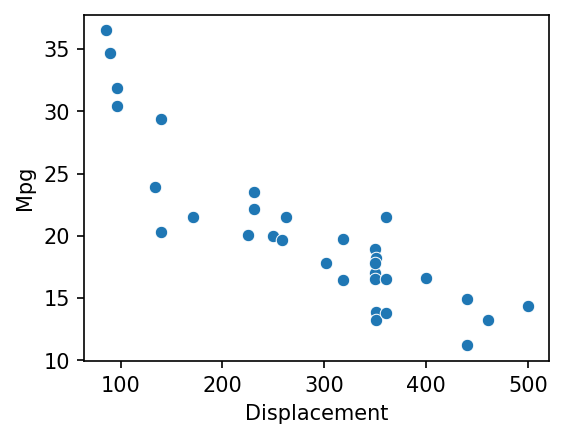

In [3]:
gas = pd.read_csv('../data/Gas_Mileage.csv')[['Mpg','Displacement']]

fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(gas,x='Displacement',y='Mpg',ax=ax)

For nearest neighbors, we do not have to standardize the response. However, we do need to standardize the predictors.

In [4]:
# extract response 
y = gas['Mpg'].values

# Extract predictors and standardize
X = gas[['Displacement']].values
X = (X-X.mean(axis=0))/X.std(axis=0)

The syntax for `KNeighborsRegressor` is very similar to the scikit-learn based estimators we have seen so far. 

In [5]:
# define a 3-nearest neighbors model and fit
# "fit" constructs a Kd tree and stores the training instances
knn = KNeighborsRegressor(n_neighbors=3).fit(X,y)

# computing predictions on training set
y_pred = knn.predict(X)

We will now visualize the effect of the number of nearest `n_neighbors` on the predictions from the model. We try 3 different values - 1,5,20.

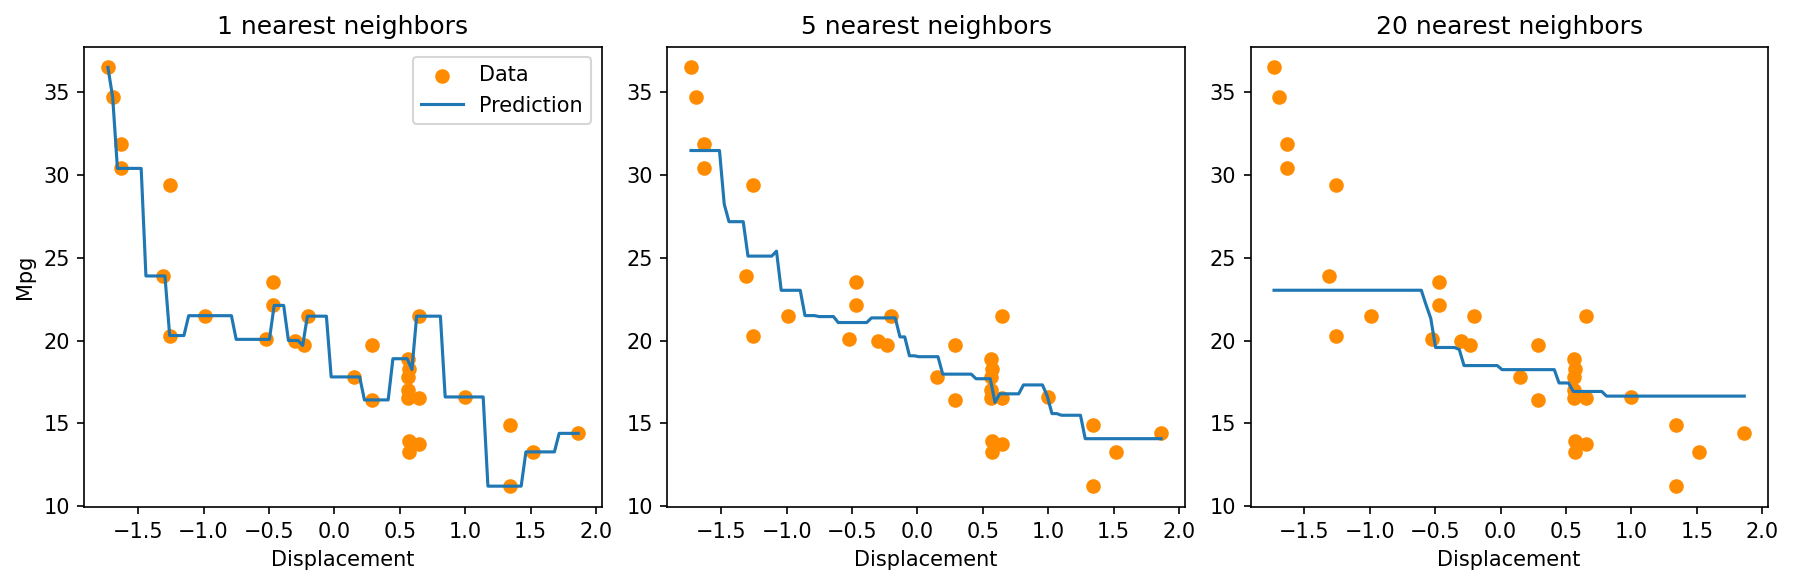

In [6]:
n_neighbors_list = [1,5,20]

X_test = np.linspace(X.min(),X.max(),100)[:,np.newaxis]

fig,axs = plt.subplots(1,3,figsize=(12,4))
for i,n_neighbors in enumerate(n_neighbors_list):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X,y)
    y_test_pred = knn.predict(X_test)
    
    
    _ = axs[i].scatter(X, y, color="darkorange", label="Data")
    _ = axs[i].plot(X_test, y_test_pred, label="Prediction")
    
    _ = axs[i].set_xlabel('Displacement')
    _ = axs[i].set_title('%d nearest neighbors'%n_neighbors)

_ = axs[0].legend()
_ = axs[0].set_ylabel('Mpg')
fig.tight_layout()

### Example: 2D classification 

We will now consider the iris dataset (available through the sklearn package). The task here is to predict the type of species (3 different kinds) as a function of 4 predictors. For illustration, we will only consider the first two predictors - sepal length and sepal width. 

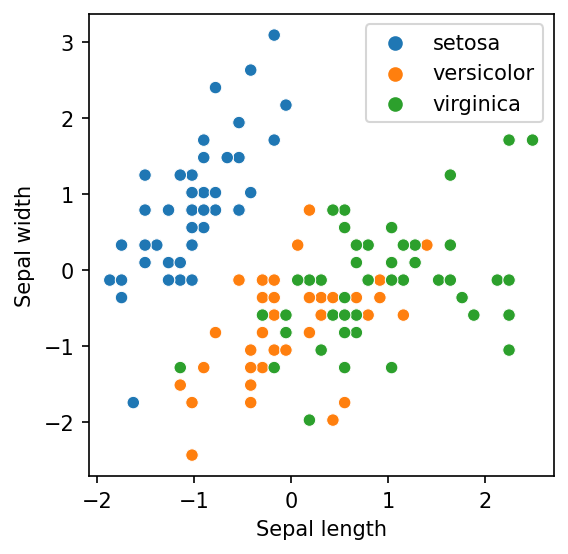

In [7]:
from sklearn.datasets import load_iris
# import the iris dataset
iris = load_iris()

# response - .target attribute is already an integer encoded numpy array
y = iris.target

# features = .data attribute 
# we only take the first two features - sepal length, sepal width
X = iris.data[:, :2]

# Standardize the features
X = (X-X.mean(0))/X.std(0)


fig,ax = plt.subplots(1,1,figsize=(4,4))
_ = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=iris.target_names[y],
    #palette=cmap_bold,
    alpha=1.0,
    ax=ax
)

_ = ax.set_xlabel('Sepal length')
_ = ax.set_ylabel('Sepal width')

We will now plot the decision boundaries for two different choices of `n_neighbors` - 1 vs 10. For this illustration, we will be using the `DecisionBoundaryDisplay` class from `sklearn.inspection` for plotting the decision boundaries.

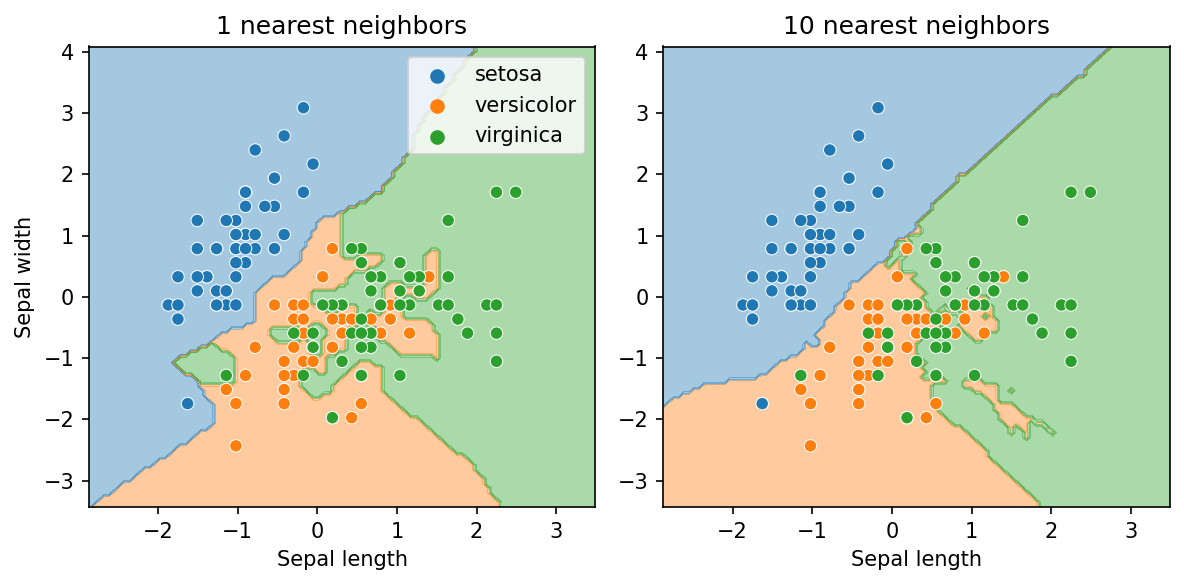

In [8]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
cmap = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:3])

n_neighbors_list = [1,10]

fig,axs = plt.subplots(1,2,figsize=(8,4))
for i,n_neighbors in enumerate(n_neighbors_list):
    
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X,y)
    
    # plot decision boundary
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axs[i], response_method="predict",cmap=cmap
    )
    
    _ = sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        alpha=1.0,
        ax=axs[i],
        legend=True if i==0 else False
    )
    
    _ = axs[i].set_xlabel('Sepal length')
    _ = axs[i].set_title('%d nearest neighbors'%n_neighbors)


_ = axs[0].set_ylabel('Sepal width')
fig.tight_layout()

## Regression on the concrete data

In [9]:
from sklearn.model_selection import GridSearchCV, KFold

In [10]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")

# extract predictors and response - standardize predictors
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

# no need to standardize the values
y = crt['Strength'].values

In [11]:
knn_tuned = GridSearchCV(
    estimator = KNeighborsRegressor(),
    param_grid= {
        'n_neighbors':[2,5,10,20]
    },
    cv = KFold(n_splits=5,shuffle=True,random_state=123),
    scoring='neg_mean_squared_error',
    refit=True
).fit(X,y)

best_cv_mse = -knn_tuned.best_score_
best_cv_r2 = 1-best_cv_mse/y.var()

print('Optimal number of nearest neighbors: %d'%knn_tuned.best_params_['n_neighbors'])
print('Best CV R-squared: %5.3f'%best_cv_r2)

Optimal number of nearest neighbors: 5
Best CV R-squared: 0.736


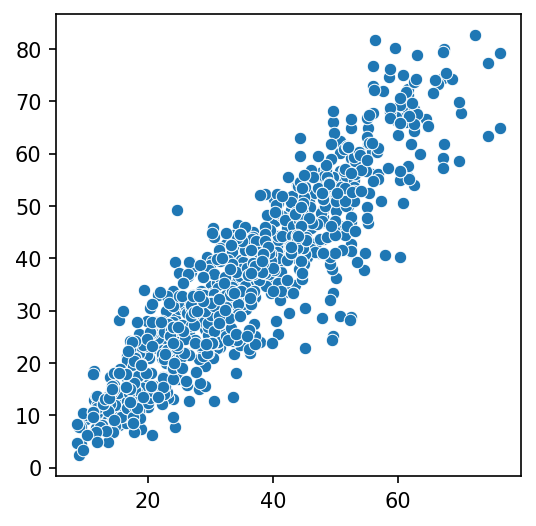

In [15]:
# plot response vs fitted values
y_pred = knn_tuned.predict(X)

fig,ax = plt.subplots(1,1,figsize=(4,4))
_ = sns.scatterplot(x=y_pred,y=y,ax=ax)

### Manually computing predictions

For new test cases, we can extract the K nearest neighbors using the `.neighbors` method. This approach is going to be similar to the approach in the R code shown in the slides

In [12]:
# find indices of 3 nearest neighbors for the 1st and 6th observation
# note: must use `.best_estimator_` method for GridSearchCV instance
distances,train_idxs = knn_tuned.best_estimator_.kneighbors(X[[0,5],:])

# 2 x 3 matrix of indices 
# rows correspond to test points
train_idxs

array([[  0,   1, 405, 401, 753],
       [  5,  53,   8,  14,  40]])

In [13]:
distances

array([[0.        , 0.19300995, 1.29386802, 1.33969622, 1.50172544],
       [0.        , 0.57141122, 0.98195672, 1.13611169, 1.14282243]])

In [14]:
# predictions for the 1th and 6th observation
# computing row means
y[train_idxs].mean(axis=1) 

array([67.51 , 48.068])

In [16]:
y_pred[[0,5]]

array([67.51 , 48.068])